#### MODEL TRAINING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras.api._v2.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD

In [ ]:
import rarfile

# Path to the RAR file
rar_file_path = "/content/drive/MyDrive/PROSTATE CANCER FILES.rar"

# Destination folder where files will be extracted
destination_folder = "/content/drive/MyDrive/PROSTATE CANCER FILES"

# Open the RAR file
with rarfile.RarFile(rar_file_path, 'r') as rf:
    # Extract all files to the destination folder
    rf.extractall(destination_folder)

print("Extraction completed.")

Extraction completed.


In [ ]:
# Set the path to the parent folder
parent_folder = "/content/drive/MyDrive/PROSTATE CANCER FILES/PROSTATE CANCER FILES/PROSTATEx"

# Load labels from the label.txt file
labels_file = os.path.join(parent_folder, "labels.txt")
labels = {}
with open(labels_file, 'r') as f:
    for line in f:
        line = line.strip()  # Remove leading/trailing whitespace
        if line:  # Check if the line is not empty
            parts = line.split(',')
            if len(parts) == 2:
                subfolder, label = parts
                labels[subfolder] = int(label)
            else:
                print(f"Skipping invalid line: {line}")

# Load and preprocess data
X_train = []
y_train = []
X_val = []
y_val = []
count = 0

for subfolder in os.listdir(parent_folder):
    subfolder_path = os.path.join(parent_folder, subfolder)

    if os.path.isdir(subfolder_path):
        concatenated_image_path = os.path.join(subfolder_path, "concatenated_image.npy")
        concatenated_image = np.load(concatenated_image_path)

        # Normalize the image
        concatenated_image = concatenated_image / 255.0

        # Get the label from the labels dictionary
        label = labels.get(subfolder, None)
        if label is None:
            continue  # Skip this subfolder if no label is available

         # Split data into training and validation sets based on count
        if count < 40:  # First 40 images for training set
            X_train.append(concatenated_image)
            y_train.append(label)
        else:  # Remaining images for validation set
            X_val.append(concatenated_image)
            y_val.append(label)

        count += 1

# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)


X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [ ]:
print(X_train.shape)
print(X_val.shape)

(40, 13, 200, 600, 1)
(10, 13, 200, 600, 1)


In [ ]:
print(y_train.shape)
print(y_val.shape)

(40,)
(10,)


#### 3D RESNET ARCHITECTURE DEEP LEARNING MODEL

In [ ]:

def identity_block_3d(input_tensor, filters, kernel_size=3):
    x = layers.Conv3D(filters, kernel_size, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block_3d(input_tensor, filters, kernel_size=3, strides=(2, 2, 2)):
    x = layers.Conv3D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv3D(filters, (1, 1, 1), strides=strides, padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_3d_resnet(input_shape):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv3D(64, (7, 7, 7), strides=(2, 2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block_3d(x, 64)
    x = identity_block_3d(x, 64)
    x = identity_block_3d(x, 64)

    x = conv_block_3d(x, 128, strides=(2, 2, 2))
    x = identity_block_3d(x, 128)
    x = identity_block_3d(x, 128)

    x = conv_block_3d(x, 256, strides=(2, 2, 2))
    x = identity_block_3d(x, 256)
    x = identity_block_3d(x, 256)

    x = conv_block_3d(x, 512, strides=(2, 2, 2))
    x = identity_block_3d(x, 512)
    x = identity_block_3d(x, 512)

    # Global Average Pooling and Output layer
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# Set input shape and build the model
input_shape = (13, 200, 600, 1)
model = build_3d_resnet(input_shape)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 200, 600, 1)]    0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 7, 100, 300, 64)      22016     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 7, 100, 300, 64)      256       ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 7, 100, 300, 64)      0         ['batch_normalization[0][0

In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
optimizer = SGD(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Convert the data to tf.data.Dataset and repeat
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=40).batch(8).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(8).repeat()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    steps_per_epoch=15,
                    validation_steps=5,
                    callbacks=[early_stopping])

Epoch 1/100
15/15 [==============================] - 22s 542ms/step - loss: 0.6238 - accuracy: 0.6833 - val_loss: 0.6599 - val_accuracy: 0.7857
Epoch 2/100
15/15 [==============================] - 6s 394ms/step - loss: 0.4945 - accuracy: 0.7583 - val_loss: 0.6454 - val_accuracy: 0.7857
Epoch 3/100
15/15 [==============================] - 7s 454ms/step - loss: 0.3117 - accuracy: 0.9583 - val_loss: 0.6169 - val_accuracy: 0.7857
Epoch 4/100
15/15 [==============================] - 6s 400ms/step - loss: 0.1471 - accuracy: 1.0000 - val_loss: 0.5928 - val_accuracy: 0.7857
Epoch 5/100
15/15 [==============================] - 6s 412ms/step - loss: 0.0897 - accuracy: 1.0000 - val_loss: 0.5765 - val_accuracy: 0.7857
Epoch 6/100
15/15 [==============================] - 6s 405ms/step - loss: 0.0842 - accuracy: 1.0000 - val_loss: 0.5577 - val_accuracy: 0.7857
Epoch 7/100
15/15 [==============================] - 7s 449ms/step - loss: 0.0524 - accuracy: 1.0000 - val_loss: 0.5425 - val_accuracy: 0.785

In [ ]:

model.save('/content/drive/MyDrive/model.h5')
print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


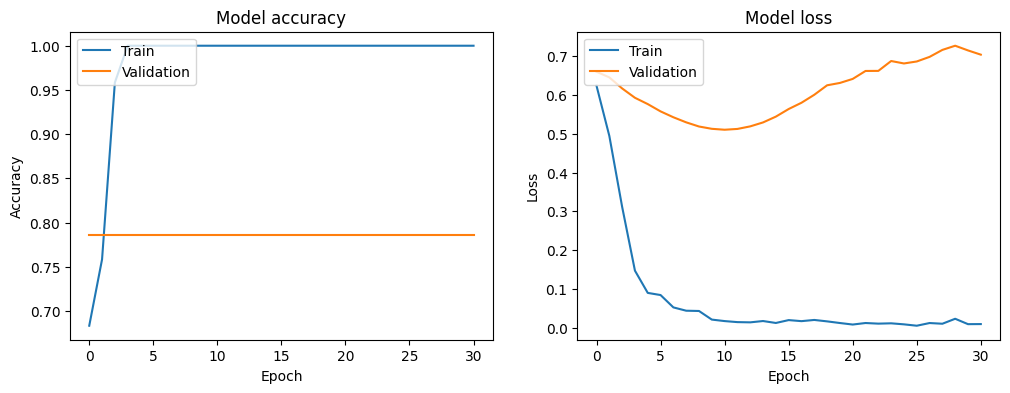

In [ ]:
# Plotting loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

##### PERFORMING EVALUATION

1/1 [==============================] - 2s 2s/step
Confusion Matrix:
 [[8 0]
 [2 0]]
Accuracy: 0.8000
Sensitivity: 0.0000
Specificity: 1.0000
ROC AUC: 0.8125


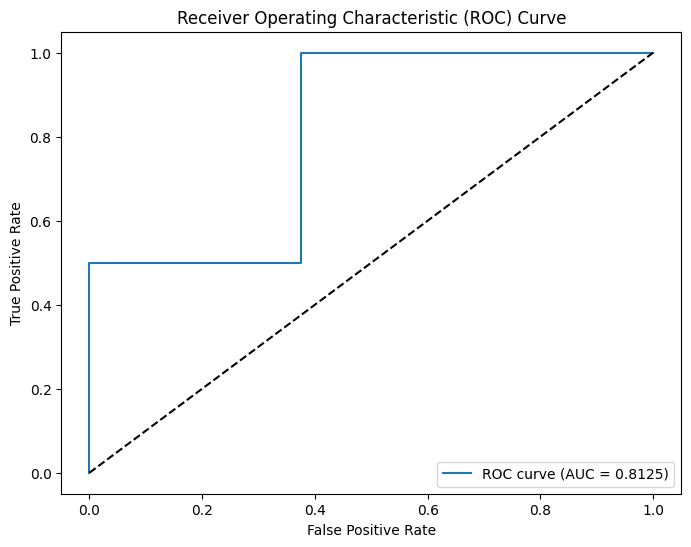

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Make predictions on the validation set
y_pred_proba = model.predict(X_val)
y_pred = np.round(y_pred_proba)  # Round predictions to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_true=y_val, y_pred=y_pred)
print("Confusion Matrix:\n", cm)

# Compute accuracy
accuracy = accuracy_score(y_true=y_val, y_pred=y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Compute sensitivity (recall) and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Compute ROC AUC
roc_auc = roc_auc_score(y_true=y_val, y_score=y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_val, y_score=y_pred_proba)

# Plot ROC curve (if desired)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

1/1 [==============================] - 0s 78ms/step
[[8 0]
 [2 0]]
0
0
2
8
accuracy is 80.0
sensitivity is 0.0
specificity is 100.0


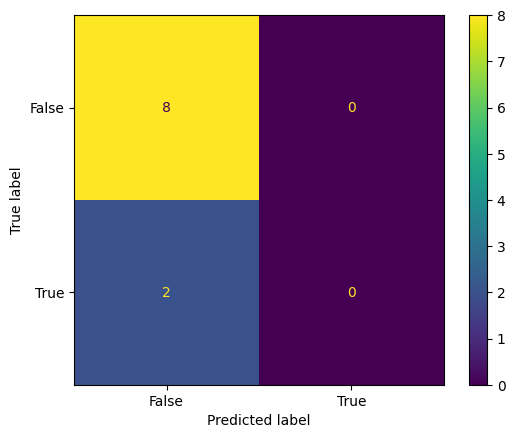

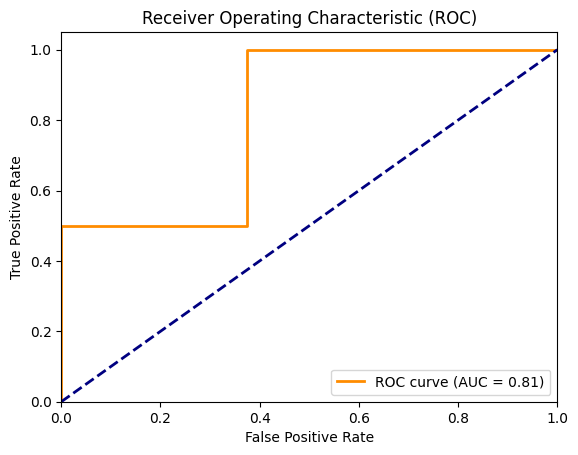

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics

preds = model.predict(X_val)
cm = confusion_matrix(y_val, np.round(preds))
print(cm)
tn, fp, fn, tp =cm.ravel()
print(fp)
print(tp)
print(fn)
print(tn)
sensitivity=((tp)/(tp+fn))*100
specificity=((tn)/(tn+fp))*100
accuracy=((tp+tn)/(tp+tn+fp+fn))*100
print(f'accuracy is {accuracy}')
print(f'sensitivity is {sensitivity}')
print(f'specificity is {specificity}')

import matplotlib.pyplot as plt
cm_display=metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[False,True])
cm_display.plot()
plt.show()


from sklearn.metrics import confusion_matrix, roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Generate predictions on the validation set
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

1/1 [==============================] - 0s 76ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[8 0]
 [2 0]]


In [ ]:
# Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


In [ ]:
# Compute sensitivity (recall)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(f"Sensitivity: {sensitivity:.2f}")

Sensitivity: 0.00


In [ ]:
# Compute specificity
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f"Specificity: {specificity:.2f}")

Specificity: 1.00


In [ ]:
# Compute ROC AUC
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f"ROC AUC: {roc_auc:.2f}")

ROC AUC: 0.81


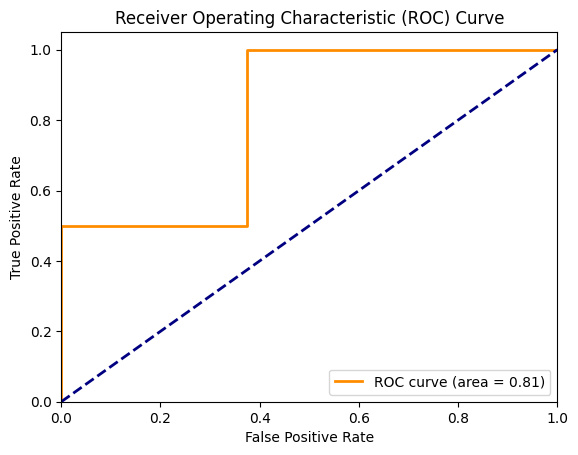

In [ ]:
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()